**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from torch.utils.data import Dataset
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
            
        augmented = self.transform(image=image,
                                   mask=mask)
        sample = {}
        sample['image'] = augmented['image']
        sample['mask'] = augmented['mask']

        return sample

In [3]:
X_train = get_paths("./data/train/images")
y_train = get_paths("./data/train/gt")

X_test = get_paths("./data/test/images")
y_test = get_paths("./data/test/gt")

train_transform = A.Compose([
    A.HorizontalFlip(),
    A.RandomRotate90(),
    A.RandomGamma(p=0.5),
#     A.ColorJitter(p=0.5),
    A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
    ], p=0.15),
    A.PadIfNeeded(min_height=384, min_width=384),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.PadIfNeeded(min_height=384, min_width=384),
    ToTensorV2(),
])

In [4]:
train_dataset = RoadDataset(X_train, y_train, train_transform)
test_dataset = RoadDataset(X_test, y_test, test_transform)

torch.Size([3, 384, 384]) torch.Size([384, 384])


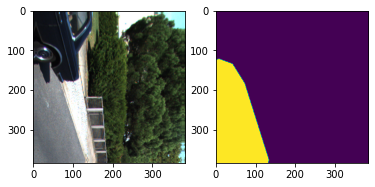

In [5]:
sample = train_dataset[4]
image = sample['image']
mask = sample['mask']

print(image.shape, mask.shape)
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [6]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

### Model U-Net

In [7]:
class ConvLayer(nn.Module):
    
    def __init__(self, input_channels, output_channels, mid_channels=None, padding=1):
        super().__init__()
        
        if mid_channels is None:
            mid_channels = output_channels
            
        self.conv1 = nn.Conv2d(in_channels=input_channels, 
                               out_channels=mid_channels,
                               kernel_size=(3, 3),
                               padding=padding,
                               dilation=1,
                               bias=False)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, 
                               out_channels=output_channels,
                               kernel_size=(3, 3),
                               padding=padding,
                               dilation=1,
                               bias=False)
        
        self.dropout = nn.Dropout(0.2)
        self.use_dropout = True
        
        self.batchnorm1 = nn.BatchNorm2d(num_features=output_channels)
        self.batchnorm2 = nn.BatchNorm2d(num_features=output_channels)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        
    
    def forward(self, input):
        x = self.conv1(input)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        
        if self.use_dropout:
            x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        
        
        return x

In [8]:
class DownScaller(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv_layer = ConvLayer(input_channels, output_channels)
    
    def forward(self, input):
        x = self.maxpool(input)
        x = self.conv_layer(x)

        return x

In [9]:
class UpScaler(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv_layer = ConvLayer(input_channels, output_channels, input_channels // 2)
        self.conv_transposed = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=2, stride=2)   
    
    def forward(self, x1, x2):
        x1 = self.conv_transposed(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv_layer(x)
        
        return x
        

In [10]:
class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()
                
        self.input_channel = 3
        self.output_channel = 16
        self.n_classes = 1
        
        self.conv1 = ConvLayer(self.input_channel, self.output_channel)
        
        self.down1 = DownScaller(self.output_channel * 1, self.output_channel * 2)
        self.down2 = DownScaller(self.output_channel * 2, self.output_channel * 4)
        self.down3 = DownScaller(self.output_channel * 4, self.output_channel * 8)
        self.down4 = DownScaller(self.output_channel * 8, self.output_channel * 16)
#         self.down5 = DownScaller(self.output_channel * 16, self.output_channel * 32)
        
#         self.up1 = UpScaler(self.output_channel * 32, self.output_channel * 16)
        self.up2 = UpScaler(self.output_channel * 16, self.output_channel * 8)
        self.up3 = UpScaler(self.output_channel * 8, self.output_channel * 4)
        self.up4 = UpScaler(self.output_channel * 4, self.output_channel * 2)
        self.up5 = UpScaler(self.output_channel * 2, self.output_channel * 1)

        self.conv3 = nn.Conv2d(self.output_channel * 1, self.n_classes, kernel_size=(3, 3), padding='same')
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self, input):
               
        x_1 = self.conv1(input)
        x_2 = self.down1(x_1)
        x_3 = self.down2(x_2)
        x_4 = self.down3(x_3)
        x_5 = self.down4(x_4)
#         x_6 = self.down5(x_5)

#         x_7 = self.up1(x_6, x_5)
        x_8 = self.up2(x_5, x_4)      
        x_9 = self.up3(x_8, x_3)
        x_10 = self.up4(x_9, x_2)
        x_11 = self.up5(x_10, x_1)
        
        output = self.conv3(x_11)
        output = self.sigmoid(output)
        
        return output

In [11]:
# CHECK
unet = UNet()
a = torch.rand([4, 3, 512, 512])
out = unet(a)

print(out.shape)

torch.Size([4, 1, 512, 512])


### Train U-Net

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 16
EPOCHS = 40
learning_rate = 0.001

In [13]:
# model = UNet().to(device)
# summary(model, input_size=train_dataset[0]['image'].shape)

In [14]:
def calc_iou(pred, target):
    pred = pred.view(-1).contiguous()
    target = target.view(-1).contiguous()

    intersection = (pred * target).sum()                            
    iou = intersection / (pred.sum() + target.sum() - intersection) 
    
    return iou

def calc_dice(pred, target, alpha = 1):
    pred = pred.view(-1).contiguous()
    target = target.view(-1).contiguous()

    intersection = (pred * target).sum()                            
    dice = (2 * intersection + alpha) / (pred.sum() + target.sum() + alpha) 
    
    return dice

def calc_focal(pred, target, alpha=0.6, gamma=4.5, smooth=1):  
    pred = pred.view(-1)
    target = target.view(-1)

    BCE = F.binary_cross_entropy(pred, target, reduction='mean')
    BCE_EXP = torch.exp(-BCE)
    focal_loss = alpha * (1 - BCE_EXP) ** gamma * BCE

    return focal_loss

def calc_loss(pred, target):
#     weights = torch.eye(target.shape[0]) * 1 + 1
    
#     bce_loss = F.binary_cross_entropy(pred, target.unsqueeze(1), 
#                                                   weight=weights.to(device)
#                                                  )
    dice_loss = 1 - calc_dice(pred, target)
#     focal_loss = calc_focal(pred, target)
    
#     loss = focal_loss + dice_loss
    
    
    
    return dice_loss

In [15]:
def train_model(model, data_loader, optimizer, epoch):
    loss_history = []
    iou_history = []
    acc_history = []
    
    for i, batch in enumerate(tqdm(data_loader, desc='TRAIN')):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).float()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        loss.backward()
           
        optimizer.step()
        optimizer.zero_grad()
        
        loss_history.append(loss.item())
        iou_history.append(calc_iou(output, 
                                    y_batch).cpu().detach().numpy())
          
        writer.add_scalars('Train', 
                   {'Loss': loss_history[-1], 'IoU': iou_history[-1]}, 
                   i + epoch * len(train_dataset) // BATCH_SIZE)
        
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}' )
    
    return model

In [16]:
@torch.no_grad()
def eval_model(model, data_loader, scheduler, epoch):
    loss_history = []
    iou_history = []
    
    for i, batch in enumerate(tqdm(data_loader, desc='VALID')):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).float()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        
        loss_history.append(loss.item() )
        iou_history.append(calc_iou(output, 
                                    y_batch).cpu().detach().numpy())
        
        writer.add_scalars('Valid', 
                           {'Loss': loss_history[-1], 'IoU': iou_history[-1]}, 
                           i + epoch * len(test_dataset) // BATCH_SIZE)
    
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}')
    
    image = test_dataset[0]['image'].to(device).float()
    pred_mask = model(image[None, :, :, :])
    
    plt.subplot(1, 2, 1)
    plt.imshow(image.cpu().permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE,
                                           num_workers=12)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, 
                                          num_workers=12)

In [18]:
# dice + focal
# increase start filters
# something with lr

2022-07-21 00:16:37.647516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/manoshin/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-21 00:16:37.647555: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Adjusting learning rate of group 0 to 1.0000e-03.


EPOCH:   0%|          | 0/40 [00:00<?, ?it/s]

-------------------------------------------------- Epoch 1 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/41 [00:00<?, ?it/s]

Loss: 0.449 ± 0.126            IoU: 0.391  ± 0.124


VALID:   0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.665 ± 0.177            IoU: 0.216  ± 0.135


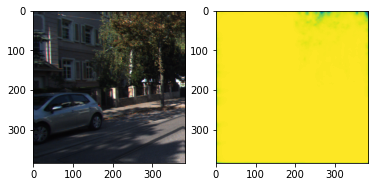

Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 2 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/41 [00:00<?, ?it/s]

Loss: 0.250 ± 0.089            IoU: 0.608  ± 0.107


VALID:   0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.340 ± 0.238            IoU: 0.537  ± 0.253


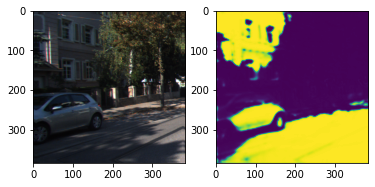

Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 3 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/41 [00:00<?, ?it/s]

Loss: 0.187 ± 0.050            IoU: 0.688  ± 0.068


VALID:   0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.461 ± 0.168            IoU: 0.388  ± 0.164


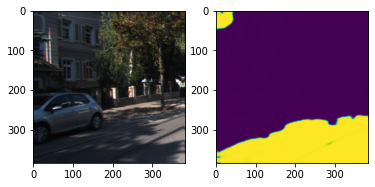

Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 4 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/41 [00:00<?, ?it/s]

Loss: 0.188 ± 0.068            IoU: 0.689  ± 0.094


VALID:   0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.335 ± 0.220            IoU: 0.536  ± 0.230


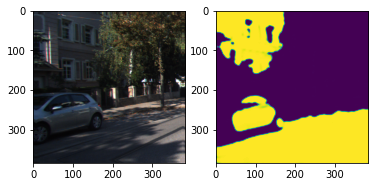

Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 5 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/41 [00:00<?, ?it/s]

Loss: 0.187 ± 0.052            IoU: 0.688  ± 0.072


VALID:   0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.286 ± 0.206            IoU: 0.592  ± 0.230


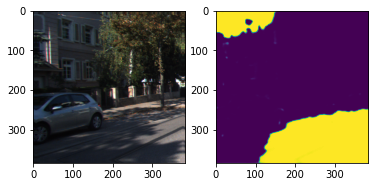

Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 6 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/41 [00:00<?, ?it/s]

Loss: 0.179 ± 0.054            IoU: 0.700  ± 0.076


VALID:   0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.248 ± 0.200            IoU: 0.638  ± 0.225


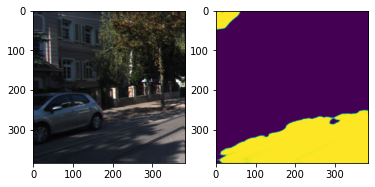

Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 7 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/41 [00:00<?, ?it/s]

Loss: 0.173 ± 0.046            IoU: 0.708  ± 0.066


VALID:   0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.286 ± 0.211            IoU: 0.593  ± 0.234


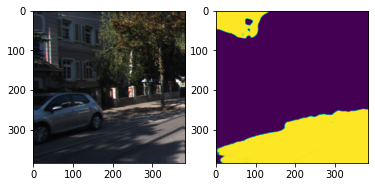

Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 8 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/41 [00:00<?, ?it/s]

Loss: 0.182 ± 0.060            IoU: 0.697  ± 0.080


VALID:   0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.294 ± 0.205            IoU: 0.582  ± 0.227


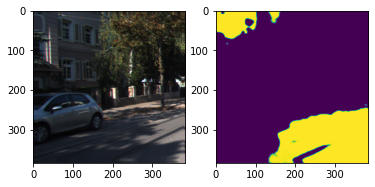

Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 9 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/41 [00:00<?, ?it/s]

Loss: 0.174 ± 0.059            IoU: 0.708  ± 0.084


VALID:   0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.236 ± 0.185            IoU: 0.650  ± 0.216


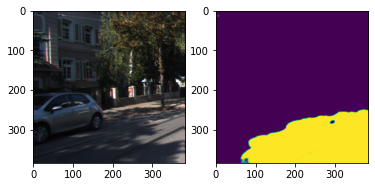

Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 10 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/41 [00:00<?, ?it/s]

Loss: 0.160 ± 0.040            IoU: 0.726  ± 0.058


VALID:   0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.283 ± 0.211            IoU: 0.597  ± 0.235


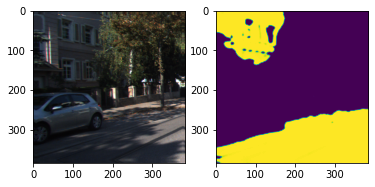

Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 11 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/41 [00:00<?, ?it/s]

Loss: 0.177 ± 0.060            IoU: 0.704  ± 0.085


VALID:   0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.275 ± 0.192            IoU: 0.602  ± 0.220


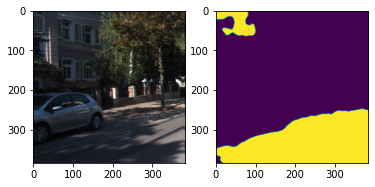

Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 12 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/41 [00:00<?, ?it/s]

Loss: 0.164 ± 0.060            IoU: 0.722  ± 0.086


VALID:   0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.264 ± 0.218            IoU: 0.624  ± 0.245


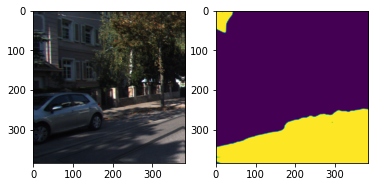

Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 13 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/41 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer = SummaryWriter(comment='_test2')

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=.55, verbose=True)

for epoch in tqdm(range(EPOCHS), desc='EPOCH'):
    print('-' * 50, f'Epoch {epoch + 1} / {EPOCHS}', '-' * 50)
    
    model.train(True) 
    model = train_model(model, train_loader, optimizer, epoch)
    
    model.train(False) 
    eval_model(model, test_loader, scheduler, epoch)
    
    scheduler.step()
    torch.cuda.empty_cache()